# Merging data with other modalities and annotations

Very often, movement is not the only thing we are working with. We might have additional data from other modalities - such as audio.

In our case, we have amplitude envelope data for each file. In this script, we will go through pipeline of merging the movement data with the amplitude envelope data.

Let's first prepare the environment

In [1]:
# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import matplotlib.pyplot as plt

curfolder = os.getcwd()

# folders with processed data
MTfolder_processed = curfolder + '\\.\\OpenPose\\TS_processed\\'
ACfolder_processed = curfolder + '\\TS_acoustics\\'
# folder to save merged data
TSmerged = curfolder + '\\TS_merged\\'

# create folder if it does not exist
if not os.path.exists(TSmerged):
    os.makedirs(TSmerged)

# prepare all files
mtfiles = glob.glob(MTfolder_processed + '/mt*.csv')
envfiles = glob.glob(ACfolder_processed + '/env*.csv')


The main challenge of merging the data is the fact that usually, different signals sample at different rates.

Let's look at the two signals we have

In [2]:
mt

NameError: name 'mt' is not defined

In [ ]:
# load from each files one and calculate the sr
mt = pd.read_csv(mtfiles[0])
env = pd.read_csv(envfiles[0])

# delete first row in mt 
mt = mt.drop(mt.index[0])
# reset index
mt = mt.reset_index(drop=True)

# calculate the sr
sr_mt = 1/(mt['Time'][1] - mt['Time'][0])
sr_env = 1/(env['time'][1] - env['time'][0])


# print them all
print('kinematics:', sr_mt*1000)
print('envelope:', sr_env*1000)

kinematics: 60.00000000000024
envelope: 48000.00000000008


There are essentially three choices on the table

- we can downsample the audio signal to the movement signal
- we can upsample the movement signal to the audio signal
- we can set new sampling rate and upsample/downsample both signals to that rate

In our case, the first and last options make equally sense. Moreover, since the sr for movement is not perfect 60 Hz, we will anyway have to create 'new' sampling rate because we want a uniform one.

Why the second option does not make much sense?

# Merging signals on a common sampling rate

In [ ]:
import warnings
warnings.filterwarnings("ignore")

desired_sr = 0.5    # this is the sr we are going to merge on (in Hz/sec)

error_log = []

for file in mtfiles:

    mt_df = pd.read_csv(file)

    # delete first row in mt 
    mt_df = mt_df.drop(mt_df.index[0])
    # reset index
    mt_df = mt_df.reset_index(drop=True)

    # get trial id
    trialid = mt_df['TrialID'][0]

    print('working on ' + trialid)
    
    # find the same trialid in envfiles
    env_file = [x for x in envfiles if trialid in x]
    try:
        env_df = pd.read_csv(env_file[0])

        # rename time to Time
        env_df.rename(columns={'time': 'Time'}, inplace=True)
    except IndexError:
        print('IndexError: ' + trialid + ' not found')
        errormessage = 'IndexError: ' + trialid + ' not found for ENV'
        error_log.append(errormessage)
        continue

    
    # rename trialID to TrialID
    env_df.rename(columns={'trialID': 'TrialID'}, inplace=True)

    ############## MERGING ########################

    #### regularize sr in motion tracking
    time_new = np.arange(0, max(mt_df['Time']), 1/desired_sr)
    mt_interp = pd.DataFrame({'Time': time_new})
    
    #########
    #  NEW merge mt with df with new time
    merge0 = pd.merge(mt_interp, mt_df, on='Time', how='outer')

    
    # interpolate all columns in file 
    colstoint = merge0.columns
    colstoint = [x for x in colstoint if 'Time' not in x]
    colstoint = [x for x in colstoint if 'TrialID' not in x]
    for col in colstoint:
        merge0[col] = merge0[col].interpolate(method='linear', x = merge0['Time'])
    ########################
    # add trialid and time
    merge0['TrialID'] = trialid


    
    ########### merge the bb_interp with env
    # merge the two dataframes
    merge1 = pd.merge(merge0, env_df, on=['Time', 'TrialID'], how='outer')


    # interpolate missing values of envelope and audio
    colstoint = merge1.columns
    colstoint = [x for x in colstoint if 'audio' in x or 'envelope' in x]

    for col in colstoint: 
        merge1[col] = merge1[col].interpolate(method='linear', x = merge1['Time'])

    # now we can kick out all values where kinematics is NaN
    merge1 = merge1[~np.isnan(merge1['RHip_x'])]

    ######### HERE WOULD COME OUR OTHER SIGNALS, IF WE HAVE THEM #######

    # this is final df
    merge_final = merge1     
   
    # write to csv
    merge_final.to_csv(TSmerged + '/merged_' + trialid + '.csv', index=False)  


working on 0_1_20_p0


In [15]:
merge0

,Time,RHip_x,RHip_z,RHip_y,RKnee_x,RKnee_z,RKnee_y,RAnkle_x,RAnkle_z,RAnkle_y,...,arm_speedKin_sum,lowerbody_accKin_sum,leg_accKin_sum,head_accKin_sum,arm_accKin_sum,lowerbody_jerkKin_sum,leg_jerkKin_sum,head_jerkKin_sum,arm_jerkKin_sum,TrialID
0,0.0,12.116297,20.421270,1.974722,13.631595,25.049763,-43.160254,16.007594,20.009471,-78.980538,...,31.596533,0.619640,1.010779,0.874263,1.802382,0.117957,0.626110,0.412346,0.658663,0_1_20_p0
1,2.0,12.115702,20.429268,1.973996,13.622632,25.016082,-43.142665,16.003199,20.010579,-78.981936,...,31.520702,0.599326,1.069140,0.829182,1.820229,0.118654,0.618761,0.413565,0.654514,0_1_20_p0
2,4.0,12.115108,20.437266,1.973271,13.613669,24.982401,-43.125077,15.998803,20.011687,-78.983335,...,31.444871,0.579012,1.127502,0.784101,1.838076,0.119350,0.611412,0.414784,0.650364,0_1_20_p0
3,6.0,12.114514,20.445264,1.972545,13.604706,24.948720,-43.107489,15.994407,20.012795,-78.984734,...,31.369040,0.558698,1.185863,0.739020,1.855924,0.120047,0.604063,0.416003,0.646215,0_1_20_p0
4,8.0,12.113920,20.453261,1.971820,13.595743,24.915039,-43.089900,15.990011,20.013903,-78.986133,...,31.293209,0.538384,1.244225,0.693939,1.873771,0.120744,0.596713,0.417222,0.642065,0_1_20_p0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,3842.0,11.282770,21.908532,2.472048,12.954491,24.009914,-41.656294,15.464842,20.274597,-78.657496,...,60.194261,5.883068,11.503546,5.503851,9.560104,2.083798,2.894763,1.555692,3.477837,0_1_20_p0
2076,3844.0,11.281340,21.902689,2.518417,12.955590,24.023289,-41.621318,15.466254,20.269197,-78.652283,...,60.932503,6.134535,11.829417,5.681771,9.939633,2.129423,2.946849,1.583813,3.525891,0_1_20_p0
2077,3846.0,11.279910,21.896847,2.564786,12.956689,24.036663,-41.586342,15.467666,20.263798,-78.647069,...,61.670745,6.386002,12.155287,5.859691,10.319161,2.175047,2.998936,1.611935,3.573945,0_1_20_p0
2078,3848.0,11.278479,21.891004,2.611155,12.957788,24.050038,-41.551366,15.469078,20.258398,-78.641855,...,62.408987,6.637470,12.481158,6.037611,10.698690,2.220672,3.051022,1.640057,3.621999,0_1_20_p0


Let's inspect a file

In [8]:
merged_files = glob.glob(TSmerged + '/merged*.csv')
sample = pd.read_csv(merged_files[2]) 

# Display
sample.head(20)

,Time,RHip_x,RHip_z,RHip_y,RKnee_x,RKnee_z,RKnee_y,RAnkle_x,RAnkle_z,RAnkle_y,...,head_accKin_sum,arm_accKin_sum,lowerbody_jerkKin_sum,leg_jerkKin_sum,head_jerkKin_sum,arm_jerkKin_sum,TrialID,audio,envelope,envelope_change
0,0.000000,11.656488,20.691806,2.790642,12.920998,24.072753,-41.951387,15.491024,20.265144,-78.672771,...,1.676633,1.828674,0.276672,0.187856,0.037101,0.585903,0_1_22_p0,-0.000031,0.000000,-0.000050
1,2.000000,11.656747,20.689281,2.782097,12.918363,24.068159,-41.948924,15.492612,20.267593,-78.668393,...,1.676558,1.803782,0.270002,0.190226,0.042943,0.588449,0_1_22_p0,0.000000,0.041884,-0.000021
2,4.000000,11.657005,20.686756,2.773552,12.915729,24.063565,-41.946462,15.494200,20.270042,-78.664014,...,1.676484,1.778890,0.263331,0.192596,0.048786,0.590994,0_1_22_p0,0.000000,0.083163,0.000007
3,6.000000,11.657264,20.684232,2.765007,12.913094,24.058972,-41.943999,15.495788,20.272491,-78.659636,...,1.676409,1.753998,0.256661,0.194967,0.054628,0.593539,0_1_22_p0,0.000000,0.123389,0.000033
4,8.000000,11.657523,20.681707,2.756462,12.910460,24.054378,-41.941536,15.497375,20.274940,-78.655258,...,1.676335,1.729107,0.249990,0.197337,0.060470,0.596084,0_1_22_p0,0.000000,0.162212,0.000057
5,10.000000,11.657782,20.679183,2.747917,12.907826,24.049784,-41.939074,15.498963,20.277389,-78.650879,...,1.676260,1.704215,0.243320,0.199707,0.066312,0.598629,0_1_22_p0,0.000000,0.199358,0.000079
6,12.000000,11.658041,20.676658,2.739373,12.905191,24.045191,-41.936611,15.500551,20.279838,-78.646501,...,1.676185,1.679323,0.236649,0.202077,0.072154,0.601174,0_1_22_p0,0.000000,0.234624,0.000098
7,14.000000,11.658300,20.674134,2.730828,12.902557,24.040597,-41.934149,15.502139,20.282287,-78.642123,...,1.676111,1.654431,0.229979,0.204447,0.077996,0.603720,0_1_22_p0,0.000000,0.267864,0.000115
8,16.000000,11.658559,20.671609,2.722283,12.899922,24.036003,-41.931686,15.503727,20.284736,-78.637744,...,1.676036,1.629539,0.223308,0.206818,0.083838,0.606265,0_1_22_p0,0.000000,0.298982,0.000129
9,16.666667,11.658818,20.669085,2.713738,12.897288,24.031409,-41.929224,15.505314,20.287185,-78.633366,...,1.675962,1.604647,0.216638,0.209188,0.089680,0.608810,0_1_22_p0,0.000000,0.308720,0.000133


And we can also nicely plot two signals together

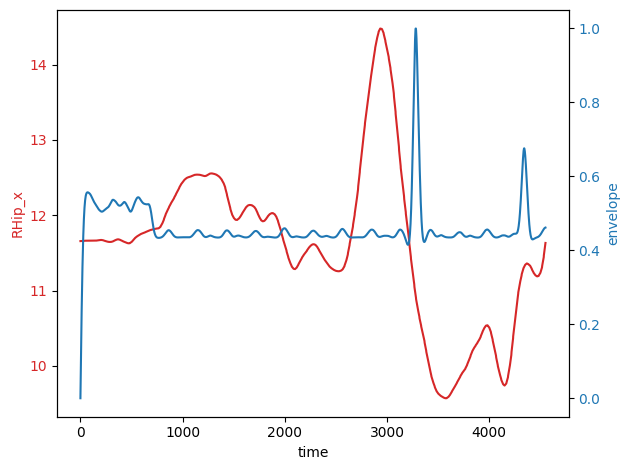

In [9]:

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('RHip_x', color=color)
ax1.plot(sample['Time'], sample['RHip_x'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('envelope', color=color)  # we already handled the x-label with ax1
ax2.plot(sample['Time'], sample['envelope'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


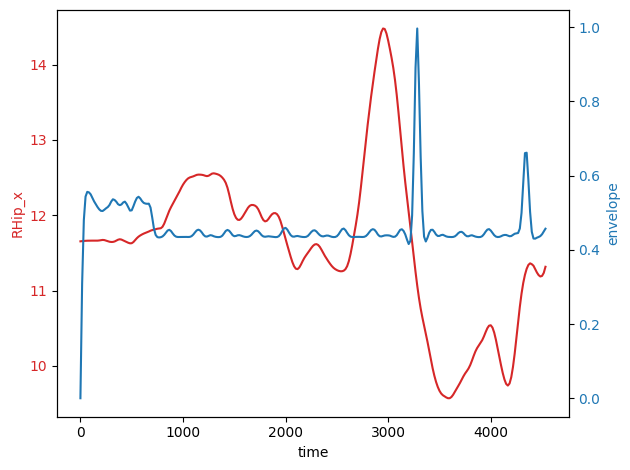

In [ ]:

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('RHip_x', color=color)
ax1.plot(sample['time'], sample['RHip_x'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('envelope', color=color)  # we already handled the x-label with ax1
ax2.plot(sample['time'], sample['envelope'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Now, let's assume we also have annotations for our videos.

In our case, Ola has been annotating the videos for presence of movement in different body regions - arms, upper body, lower body, and head.

In [49]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd

curfolder = os.getcwd()

# Here we store the merged timeseries data
mergedfolder = curfolder + '\\TS_merged\\'
mergedfiles = glob.glob(mergedfolder + '/merged*.csv')
mergedfiles = [x for x in mergedfiles if 'anno' not in x]

# Here we store the predicted motion annotations
annofolder = curfolder + '\\ManualAnno\\'
annofiles = glob.glob(annofolder + '*.eaf')

# Create folder for the txt annotations
if not os.path.exists(curfolder + '\\Annotations_txt'):
    os.makedirs(curfolder + '\\Annotations_txt')

txtannofolder = curfolder + '\\Annotations_txt\\'

In [50]:
import xml.etree.ElementTree as ET

# Function to parse elan file
def parse_eaf_file(eaf_file, rel_tiers):
    tree = ET.parse(eaf_file)
    root = tree.getroot()

    annotations = []
    relevant_tiers = {rel_tiers}
    
    time_order = root.find('TIME_ORDER')
    if time_order == None: 
        print ("no time order")
        print()
        annotations.append({
                        'tier_id': 'na',
                        'annotation_id': 'na',
                        'start_time': 'na',
                        'end_time': 'na',
                        'annotation_value': None
                    })
    else:
        time_slots = {time_slot.attrib['TIME_SLOT_ID']: time_slot.attrib['TIME_VALUE'] for time_slot in time_order}


        for tier in root.findall('TIER'):
            tier_id = tier.attrib['TIER_ID']
            if tier_id in relevant_tiers:
                for annotation in tier.findall('ANNOTATION/ALIGNABLE_ANNOTATION'):
                    # Ensure required attributes are present
                    if 'TIME_SLOT_REF1' in annotation.attrib and 'TIME_SLOT_REF2' in annotation.attrib:
                        ts_ref1 = annotation.attrib['TIME_SLOT_REF1']
                        ts_ref2 = annotation.attrib['TIME_SLOT_REF2']
                        # Get annotation ID if it exists, otherwise set to None
                        ann_id = annotation.attrib.get('ANNOTATION_ID', None)
                        annotation_value = annotation.find('ANNOTATION_VALUE').text.strip()
                        annotations.append({
                            'tier_id': tier_id,
                            'annotation_id': ann_id,
                            'start_time': time_slots[ts_ref1],
                            'end_time': time_slots[ts_ref2],
                            'annotation_value': annotation_value
                        })

    return annotations

# Function to load annotations into csv
def fillAnno(TSfile, ANNOfile, colname):
    TSfile[colname] = None
    for row in ANNOfile.iterrows():
        start = float(row[1][0])
        end = float(row[1][1])
        value = str(row[1][2])
        TSfile.loc[(TSfile['time'] >= start) & (TSfile['time'] <= end), colname] = value

In [51]:

################
#### arms ######
################


arms_anno = txtannofolder + '/arms_annotations.txt'


with open(arms_anno, 'w') as f:
    for file in annofiles:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        # replace _ELAN_tiers.eaf with ''
        filename = filename.replace('_ELAN_tiers.eaf', '')
        print('filename:')
        print(filename)
        # parse the file
        annotations = parse_eaf_file(file, 'arms')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

###################
#### upper body####
###################

upperbody_anno = txtannofolder + '/upperbody_annotations.txt'

with open(upperbody_anno, 'w') as f:
    for file in annofiles:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        # replace _ELAN_tiers.eaf with ''
        filename = filename.replace('_ELAN_tiers.eaf', '')
        annotations = parse_eaf_file(file, 'upper_body')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

###################
#### lower body####
###################

lowerbody_anno = txtannofolder + '/lowerbody_annotations.txt'

with open(lowerbody_anno, 'w') as f:
    for file in annofiles:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        # replace _ELAN_tiers.eaf with ''
        filename = filename.replace('_ELAN_tiers.eaf', '')
        # parse the file
        annotations = parse_eaf_file(file, 'lower_body')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

###################
##### head ########
###################

head_anno = txtannofolder + '/head_annotations.txt'

with open(head_anno, 'w') as f:
    for file in annofiles:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        # replace _ELAN_tiers.eaf with ''
        filename = filename.replace('_ELAN_tiers.eaf', '')
        # parse the file
        annotations = parse_eaf_file(file, 'head_mov')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")


working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing\ManualAnno\0_1_20_p0_ELAN_tiers.eaf
filename:
0_1_20_p0
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing\ManualAnno\0_1_21_p0_ELAN_tiers.eaf
filename:
0_1_21_p0
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing\ManualAnno\0_1_22_p0_ELAN_tiers.eaf
filename:
0_1_22_p0
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing\ManualAnno\0_1_23_p0_ELAN_tiers.eaf
filename:
0_1_23_p0
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing\ManualAnno\0_1_24_p0_ELAN_tiers.eaf
filename:
0_1_24_p0
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing\ManualAnno\0_1_25_p0_ELAN_tiers.eaf
filename:
0_1_25_p0
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing\ManualAnno\0_1_26_p0_ELAN_tiers.eaf
filename:
0_1_26_p0
working on e:\workshop\MotionTrackingPipe

Now we can merge our merged signals with the annotations

In [53]:
arms

,0,1,2,3
0,650,3750,movement,0_1_20_p0
1,0,650,nomovement,0_1_20_p0
2,3750,3881,nomovement,0_1_20_p0
3,610,3450,movement,0_1_21_p0
4,0,610,nomovement,0_1_21_p0
5,3450,3595,nomovement,0_1_21_p0
6,560,2160,movement,0_1_22_p0
7,0,560,nomovement,0_1_22_p0
8,2160,4575,nomovement,0_1_22_p0
9,955,3725,movement,0_1_23_p0


In [58]:

# These are the annotations per tier that we just created from manual annotations
arms_anno = txtannofolder + '/arms_annotations.txt'
upperbody_anno = txtannofolder + '/upperbody_annotations.txt'
lowerbody_anno = txtannofolder + '/lowerbody_annotations.txt'
head_anno = txtannofolder + '/head_annotations.txt'

curfolder = os.getcwd()
mergedfolder = curfolder + '/TS_merged/'
mergedfiles = glob.glob(mergedfolder + '*.csv')

finalfolder = curfolder + '/TS_annotated/'

# Create TS_annotated
if not os.path.exists(curfolder + '/TS_annotated'):
    os.makedirs(curfolder + '/TS_annotated')

for file in mergedfiles:
    print('working on ' + file)

    # Load the merged file
    merged = pd.read_csv(file)

    # Get the trialid
    trialid = merged['TrialID'][0]
    
    # Load the annotations as df
    arms = pd.read_csv(arms_anno, sep='\t', header=None)
    ub = pd.read_csv(upperbody_anno, sep='\t', header=None)
    lb = pd.read_csv(lowerbody_anno, sep='\t', header=None)
    head = pd.read_csv(head_anno, sep='\t', header=None)

    #print(arms)
    
    annos = [arms, ub, lb, head]

    # Loop over each tier and fill values into timeseries
    for anno_df in annos:
        # Get the annotations for the trialid
        anno_trial = anno_df[anno_df[3] == trialid] 
        
        if anno_trial.empty:
            print("empty")
            print('no annotations for ' + trialid)
            #add a column
            continue
        
        else:
            if anno_df.equals(arms):
                fillAnno(merged, anno_trial, 'arms')
            elif anno_df.equals(ub):
                fillAnno(merged, anno_trial, 'upper_body')
            elif anno_df.equals(lb):
                fillAnno(merged, anno_trial, 'lower_body')
            elif anno_df.equals(head):
                fillAnno(merged, anno_trial, 'head_mov')
            else:
                print('something went wrong')

    df = merged.copy()

    # check if each column exists in the dataframe
    col1 = 'arms'
    col2 = 'upper_body'
    col3 = 'lower_body'
    col4 = 'head_mov'


    # create a column if it doesn't exist. If it does, switch the labels. 
    if col1 not in df:
        df[col1] = 'no movement'
    else:
        df['arms'] = df['arms'].fillna('no movement')

    if col2 not in df:
        df[col2] = 'no movement'
    else:
        df['upper_body'] = df['upper_body'].fillna('no movement')

    if col3 not in df:
        df[col3] = 'no movement'
    else:
        df['lower_body'] = df['lower_body'].fillna('no movement')

    if col4 not in df:
        df[col4] = 'no movement'
    else:
        df['head_mov'] = df['head_mov'].fillna('no movement')

    # save the dataframe to TS_annotated
    df.to_csv(finalfolder + 'annotated_' + trialid + '.csv', index=False)



working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_20_p0.csv
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_21_p0.csv
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_22_p0.csv
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_23_p0.csv
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_24_p0.csv
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_25_p0.csv
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_26_p0.csv
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_29_p1.csv
working on e:\workshop\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing/TS_merged\merged_0_1_30

Now we can again inspect a file

In [33]:
annofiles = glob.glob(finalfolder + '\*.csv')
sample = pd.read_csv(annofiles[2]) 

# Display
sample.head(20)

,time,RHip_x,RHip_z,RHip_y,RKnee_x,RKnee_z,RKnee_y,RAnkle_x,RAnkle_z,RAnkle_y,...,head_jerkKin_sum,arm_jerkKin_sum,TrialID,audio,envelope,envelope_change,arms,upper_body,lower_body,head_mov
0,0.000000,11.653420,20.717980,2.876870,12.960391,24.132799,-42.011133,15.467765,20.239747,-78.725424,...,0.182249,0.555537,0_1_22_p0,-0.000031,0.000000,-0.000050,nomovement,nomovement,nomovement,nomovement
1,16.666667,11.656488,20.691806,2.790642,12.920998,24.072753,-41.951387,15.491024,20.265144,-78.672771,...,0.036966,0.583765,0_1_22_p0,0.000000,0.308872,0.000133,nomovement,nomovement,nomovement,nomovement
2,33.333333,11.658818,20.669085,2.713738,12.897288,24.031409,-41.929224,15.505314,20.287185,-78.633366,...,0.089353,0.606588,0_1_22_p0,0.000000,0.480444,0.000155,nomovement,nomovement,nomovement,nomovement
3,50.000000,11.660505,20.649593,2.645815,12.887283,24.006423,-41.939383,15.511917,20.305953,-78.605811,...,0.179029,0.604478,0_1_22_p0,0.000000,0.543659,0.000094,nomovement,nomovement,nomovement,nomovement
4,66.666667,11.661641,20.633105,2.586529,12.889002,23.995448,-41.976604,15.512112,20.321528,-78.588706,...,0.243757,0.572595,0_1_22_p0,-0.000031,0.556377,0.000035,nomovement,nomovement,nomovement,nomovement
5,83.333333,11.662318,20.619395,2.535535,12.900466,23.996137,-42.035625,15.507182,20.333991,-78.580652,...,0.285399,0.512668,0_1_22_p0,0.000015,0.554943,0.000007,nomovement,nomovement,nomovement,nomovement
6,100.000000,11.662631,20.608238,2.492490,12.919696,24.006146,-42.111186,15.498408,20.343424,-78.580251,...,0.306329,0.429791,0_1_22_p0,0.000031,0.549635,0.000002,nomovement,nomovement,nomovement,nomovement
7,116.666667,11.662671,20.599408,2.457048,12.944713,24.023128,-42.198025,15.487070,20.349909,-78.586102,...,0.308984,0.331974,0_1_22_p0,0.000000,0.540210,0.000006,nomovement,nomovement,nomovement,nomovement
8,133.333333,11.662531,20.592680,2.428866,12.973535,24.044736,-42.290882,15.474450,20.353525,-78.596807,...,0.295820,0.233342,0_1_22_p0,0.000000,0.530700,0.000009,nomovement,nomovement,nomovement,nomovement
9,150.000000,11.662305,20.587830,2.407599,13.004185,24.068626,-42.384495,15.461829,20.354355,-78.610967,...,0.269313,0.168463,0_1_22_p0,0.000031,0.523207,0.000010,nomovement,nomovement,nomovement,nomovement
